In [1]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip "/content/drive/My Drive/loader_util.zip"

Archive:  /content/drive/My Drive/loader_util.zip
   creating: loader_util/
   creating: loader_util/callbacks/
  inflating: loader_util/callbacks/epochcheckpoint.py  
  inflating: loader_util/callbacks/trainingmonitor.py  
  inflating: loader_util/callbacks/__init__.py  
   creating: loader_util/callbacks/__pycache__/
  inflating: loader_util/callbacks/__pycache__/epochcheckpoint.cpython-36.pyc  
  inflating: loader_util/callbacks/__pycache__/trainingmonitor.cpython-36.pyc  
  inflating: loader_util/callbacks/__pycache__/__init__.cpython-36.pyc  
   creating: loader_util/datasets/
  inflating: loader_util/datasets/simpledatasetloader.py  
  inflating: loader_util/datasets/torch_dataset_loader.py  
  inflating: loader_util/datasets/torch_train_test_split.py  
  inflating: loader_util/datasets/__init__.py  
   creating: loader_util/datasets/__pycache__/
  inflating: loader_util/datasets/__pycache__/simpledatasetloader.cpython-36.pyc  
  inflating: loader_util/datasets/__pycache__/torch_

In [1]:
import os
import h5py
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
from imutils import paths
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import matplotlib.axes._axes as axes
sns.set()

In [2]:
# import the necessary packages
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from loader_util.preprocessing import ImageToArrayPreprocessor, \
    AspectAwarePreprocessor, MeanSubtractionPreProcessor, SimplePreProcessor
from loader_util.datasets import SimpleDatasetLoader
from loader_util.io import HDF5DatasetGenerator
from loader_util.nn.conv import FCHeadNet, LeNet, AlexNet, MinVGGNet, MiniGoogleNet, DeeperGoogleNet
from loader_util.callbacks import TrainingMonitor, EpochCheckpoint
##
from tensorflow.keras.layers import Conv2D, Activation, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import LearningRateScheduler

In [3]:
# construct the train image generator
aug = ImageDataGenerator(rotation_range=20,
                         zoom_range=0.15,
                         width_shift_range=0.2,
                         height_shift_range=0.2,
                         shear_range=0.15,
                         horizontal_flip=True,
                         fill_mode='nearest')

In [4]:
batch_size = 32
epoch_num = 600
image_size = 28

# initialise the image preprocessors
sp = SimplePreProcessor(width=image_size, height=image_size)
iap = ImageToArrayPreprocessor()

In [5]:
# initialise the data paths

dbBase = r"C:\Users\mhasa\GDrive\mvcnn"
dbTrainPath = f"{dbBase}//train_mvcnn_color_roi_10class_28px1px_255.hdf5"
dbValidPath = f"{dbBase}//test_mvcnn_color_roi_10class_28px1px_255.hdf5"

# get the no. of classes
trainFile = h5py.File(name=dbTrainPath, mode="r")
class_num = len(list(np.unique(trainFile["labels"])))
print(f"Total no. of classes in dataset: {class_num}")

# get unique labels
labels = list(trainFile["label_names"])
labels = [label.decode() for label in labels]
print(f"Unique Labels: {labels}")

Total no. of classes in dataset: 10
Unique Labels: ['Brackets', 'Bulky', 'Cylindrical', 'Gasket', 'HeadlessScrews', 'Nuts', 'O-Rings', 'Pipes', 'Springs', 'Toothy']


In [6]:
# consider class weight discrepency
le = LabelEncoder()
labels = le.fit_transform(trainFile["labels"])
encoded_labels = to_categorical(labels)

classLabels = le.classes_
classTotals = encoded_labels.sum(axis=0) # type: np.ndarray
classWeight = classTotals.max() / classTotals

print(f"ClassLabels: {classLabels}")
print(f"ClassWeights: {classWeight}")

ClassLabels: [0 1 2 3 4 5 6 7 8 9]
ClassWeights: [5.9427314 2.48893   4.014881  4.401305  2.0850077 3.6508796 1.
 3.3809524 1.4536638 4.870036 ]


In [7]:
# initialise the train and valid generators
trainGen = HDF5DatasetGenerator(dbPath=dbTrainPath,
                                batchSize=batch_size,
                                preprocessors=[sp, iap],
                                classes=class_num,
                                aug=aug)

valGen = HDF5DatasetGenerator(dbPath=dbValidPath,
                              batchSize=batch_size,
                              preprocessors=[sp, iap],
                              classes=class_num)

In [8]:
# define the Learning Rate Scheduler

initial_rate = 5e-3

def poly_decay(epoch):
    max_epochs = epoch_num
    baseLR = initial_rate
    power = 1.0
    
    alpha = baseLR * (1 - (epoch / float(max_epochs))) ** power
    return alpha

In [9]:
# model = AlexNet.build(width=32, height=32, depth=3, classes=class_num)
# model = LeNet.build(width=28,
#                     height=28,
#                     depth=1,
#                     classes=len(classLabels))

model = MinVGGNet.build(width=28,
                    height=28,
                    depth=1,
                    classes=len(classLabels))

# model = MiniGoogleNet.build(width=28, height=28, depth=1, classes=class_num)
#model =DeeperGoogleNet.build(width=image_size, height=image_size, depth=1, classes=class_num)

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
activation (Activation)      (None, 28, 28, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0

In [11]:
# compile and optimise model
opt = Adam(lr=initial_rate)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# construct callbacks
path = os.path.sep.join([dbBase, f'{os.getpid()}.png'])
callbacks = [TrainingMonitor(path),
             LearningRateScheduler(poly_decay),]
             #EpochCheckpoint(outputPath=dbBase)]

In [12]:

classWeight = {i : classWeight[i] for i in range(len(classWeight))}
classWeight

{0: 5.9427314,
 1: 2.48893,
 2: 4.014881,
 3: 4.401305,
 4: 2.0850077,
 5: 3.6508796,
 6: 1.0,
 7: 3.3809524,
 8: 1.4536638,
 9: 4.870036}

In [13]:
# train the head for few epochs
H = model.fit_generator(
    trainGen.generator(),
    steps_per_epoch=trainGen.numImages//batch_size,
    validation_data=valGen.generator(),
    validation_steps=valGen.numImages//batch_size,
    epochs=epoch_num,
    max_queue_size=10,
    verbose=1,
    callbacks=callbacks,
    class_weight=classWeight
)

Epoch 1/600
336/336 [==============================] - 45s 133ms/step - loss: 4.4066 - accuracy: 0.4622 - val_loss: 6.4125 - val_accuracy: 0.1267
Epoch 2/600
336/336 [==============================] - 32s 95ms/step - loss: 3.1087 - accuracy: 0.5858 - val_loss: 1.5449 - val_accuracy: 0.4916
Epoch 3/600
336/336 [==============================] - 32s 95ms/step - loss: 2.6988 - accuracy: 0.6404 - val_loss: 0.9359 - val_accuracy: 0.6756
Epoch 4/600
336/336 [==============================] - 31s 91ms/step - loss: 2.3745 - accuracy: 0.6860 - val_loss: 0.6480 - val_accuracy: 0.7992
Epoch 5/600
336/336 [==============================] - 31s 92ms/step - loss: 2.0209 - accuracy: 0.7312 - val_loss: 0.6341 - val_accuracy: 0.8031
Epoch 6/600
336/336 [==============================] - 32s 95ms/step - loss: 1.8529 - accuracy: 0.7544 - val_loss: 0.5834 - val_accuracy: 0.8182
Epoch 7/600
336/336 [==============================] - 32s 95ms/step - loss: 1.8639 - accuracy: 0.7577 - val_loss: 1.3754 - val_a

336/336 [==============================] - 36s 108ms/step - loss: 0.6432 - accuracy: 0.9181 - val_loss: 0.4691 - val_accuracy: 0.8933
Epoch 58/600
336/336 [==============================] - 35s 105ms/step - loss: 0.6435 - accuracy: 0.9162 - val_loss: 0.2079 - val_accuracy: 0.9415
Epoch 59/600
336/336 [==============================] - 35s 104ms/step - loss: 0.5648 - accuracy: 0.9247 - val_loss: 0.2079 - val_accuracy: 0.9440
Epoch 60/600
336/336 [==============================] - 35s 104ms/step - loss: 0.6014 - accuracy: 0.9221 - val_loss: 0.1594 - val_accuracy: 0.9522
Epoch 61/600
336/336 [==============================] - 34s 100ms/step - loss: 0.6147 - accuracy: 0.9244 - val_loss: 0.1328 - val_accuracy: 0.9568
Epoch 62/600
336/336 [==============================] - 36s 106ms/step - loss: 0.6277 - accuracy: 0.9197 - val_loss: 0.1585 - val_accuracy: 0.9478
Epoch 63/600
336/336 [==============================] - 35s 103ms/step - loss: 0.5936 - accuracy: 0.9228 - val_loss: 0.1374 - val_a

336/336 [==============================] - 34s 101ms/step - loss: 0.4142 - accuracy: 0.9469 - val_loss: 0.2040 - val_accuracy: 0.9454
Epoch 113/600
336/336 [==============================] - 32s 97ms/step - loss: 0.4092 - accuracy: 0.9466 - val_loss: 0.3375 - val_accuracy: 0.9090
Epoch 114/600
336/336 [==============================] - 33s 99ms/step - loss: 0.4348 - accuracy: 0.9458 - val_loss: 0.2981 - val_accuracy: 0.9253
Epoch 115/600
336/336 [==============================] - 34s 102ms/step - loss: 0.4417 - accuracy: 0.9426 - val_loss: 0.1297 - val_accuracy: 0.9640
Epoch 116/600
336/336 [==============================] - 34s 100ms/step - loss: 0.4010 - accuracy: 0.9455 - val_loss: 0.1488 - val_accuracy: 0.9585
Epoch 117/600
336/336 [==============================] - 33s 99ms/step - loss: 0.4340 - accuracy: 0.9432 - val_loss: 0.1524 - val_accuracy: 0.9605
Epoch 118/600
336/336 [==============================] - 33s 98ms/step - loss: 0.4321 - accuracy: 0.9432 - val_loss: 0.2252 - val

336/336 [==============================] - 33s 97ms/step - loss: 0.3437 - accuracy: 0.9539 - val_loss: 0.3179 - val_accuracy: 0.9249
Epoch 168/600
336/336 [==============================] - 33s 97ms/step - loss: 0.3266 - accuracy: 0.9570 - val_loss: 0.1214 - val_accuracy: 0.9697
Epoch 169/600
336/336 [==============================] - 34s 100ms/step - loss: 0.3451 - accuracy: 0.9554 - val_loss: 0.1441 - val_accuracy: 0.9603
Epoch 170/600
336/336 [==============================] - 33s 99ms/step - loss: 0.3987 - accuracy: 0.9493 - val_loss: 0.2874 - val_accuracy: 0.9153
Epoch 171/600
336/336 [==============================] - 33s 98ms/step - loss: 0.3509 - accuracy: 0.9530 - val_loss: 0.6802 - val_accuracy: 0.8633
Epoch 172/600
336/336 [==============================] - 33s 98ms/step - loss: 0.3176 - accuracy: 0.9582 - val_loss: 0.4204 - val_accuracy: 0.9325
Epoch 173/600
336/336 [==============================] - 33s 98ms/step - loss: 0.2982 - accuracy: 0.9600 - val_loss: 0.1236 - val_a

336/336 [==============================] - 37s 110ms/step - loss: 0.2866 - accuracy: 0.9627 - val_loss: 0.1213 - val_accuracy: 0.9729
Epoch 223/600
336/336 [==============================] - 35s 105ms/step - loss: 0.2655 - accuracy: 0.9670 - val_loss: 0.1716 - val_accuracy: 0.9657
Epoch 224/600
336/336 [==============================] - 35s 104ms/step - loss: 0.2614 - accuracy: 0.9660 - val_loss: 0.1174 - val_accuracy: 0.9766
Epoch 225/600
336/336 [==============================] - 37s 109ms/step - loss: 0.2946 - accuracy: 0.9628 - val_loss: 0.1143 - val_accuracy: 0.9712
Epoch 226/600
336/336 [==============================] - 33s 98ms/step - loss: 0.2695 - accuracy: 0.9652 - val_loss: 0.1477 - val_accuracy: 0.9655
Epoch 227/600
336/336 [==============================] - 34s 100ms/step - loss: 0.2753 - accuracy: 0.9661 - val_loss: 0.1307 - val_accuracy: 0.9729
Epoch 228/600
336/336 [==============================] - 34s 100ms/step - loss: 0.2624 - accuracy: 0.9654 - val_loss: 0.1280 - 

336/336 [==============================] - 34s 102ms/step - loss: 0.2230 - accuracy: 0.9699 - val_loss: 0.1262 - val_accuracy: 0.9718
Epoch 278/600
336/336 [==============================] - 38s 114ms/step - loss: 0.2043 - accuracy: 0.9728 - val_loss: 0.1429 - val_accuracy: 0.9677
Epoch 279/600
336/336 [==============================] - 37s 111ms/step - loss: 0.2354 - accuracy: 0.9697 - val_loss: 0.1228 - val_accuracy: 0.9705
Epoch 280/600
336/336 [==============================] - 38s 115ms/step - loss: 0.2539 - accuracy: 0.9699 - val_loss: 0.1389 - val_accuracy: 0.9668
Epoch 281/600
336/336 [==============================] - 42s 126ms/step - loss: 0.2231 - accuracy: 0.9680 - val_loss: 0.1040 - val_accuracy: 0.9764
Epoch 282/600
336/336 [==============================] - 36s 109ms/step - loss: 0.2283 - accuracy: 0.9725 - val_loss: 0.1016 - val_accuracy: 0.9745
Epoch 283/600
336/336 [==============================] - 36s 108ms/step - loss: 0.2278 - accuracy: 0.9714 - val_loss: 0.1180 -

336/336 [==============================] - 37s 109ms/step - loss: 0.2278 - accuracy: 0.9713 - val_loss: 0.1190 - val_accuracy: 0.9712
Epoch 333/600
336/336 [==============================] - 35s 106ms/step - loss: 0.2105 - accuracy: 0.9715 - val_loss: 0.1158 - val_accuracy: 0.9747
Epoch 334/600
336/336 [==============================] - 36s 108ms/step - loss: 0.1967 - accuracy: 0.9748 - val_loss: 0.2121 - val_accuracy: 0.9622
Epoch 335/600
336/336 [==============================] - 34s 101ms/step - loss: 0.2068 - accuracy: 0.9737 - val_loss: 0.0962 - val_accuracy: 0.9784
Epoch 336/600
336/336 [==============================] - 34s 101ms/step - loss: 0.1769 - accuracy: 0.9764 - val_loss: 0.1226 - val_accuracy: 0.9749
Epoch 337/600
336/336 [==============================] - 34s 101ms/step - loss: 0.1957 - accuracy: 0.9744 - val_loss: 0.1158 - val_accuracy: 0.9729
Epoch 338/600
336/336 [==============================] - 34s 101ms/step - loss: 0.1923 - accuracy: 0.9741 - val_loss: 0.0966 -

336/336 [==============================] - 33s 97ms/step - loss: 0.1468 - accuracy: 0.9791 - val_loss: 0.1225 - val_accuracy: 0.9747
Epoch 388/600
336/336 [==============================] - 33s 99ms/step - loss: 0.1583 - accuracy: 0.9783 - val_loss: 0.1043 - val_accuracy: 0.9771
Epoch 389/600
336/336 [==============================] - 34s 100ms/step - loss: 0.1471 - accuracy: 0.9802 - val_loss: 0.1045 - val_accuracy: 0.9769
Epoch 390/600
336/336 [==============================] - 36s 106ms/step - loss: 0.1553 - accuracy: 0.9791 - val_loss: 0.1193 - val_accuracy: 0.9760
Epoch 391/600
336/336 [==============================] - 34s 101ms/step - loss: 0.1512 - accuracy: 0.9787 - val_loss: 0.1270 - val_accuracy: 0.9760
Epoch 392/600
336/336 [==============================] - 33s 100ms/step - loss: 0.1493 - accuracy: 0.9795 - val_loss: 0.1260 - val_accuracy: 0.9740
Epoch 393/600
336/336 [==============================] - 33s 98ms/step - loss: 0.1627 - accuracy: 0.9789 - val_loss: 0.1071 - va

336/336 [==============================] - 37s 109ms/step - loss: 0.1417 - accuracy: 0.9807 - val_loss: 0.1225 - val_accuracy: 0.9736
Epoch 443/600
336/336 [==============================] - 37s 111ms/step - loss: 0.1267 - accuracy: 0.9837 - val_loss: 0.1023 - val_accuracy: 0.9797
Epoch 444/600
336/336 [==============================] - 45s 134ms/step - loss: 0.1170 - accuracy: 0.9837 - val_loss: 0.1286 - val_accuracy: 0.9753
Epoch 445/600
336/336 [==============================] - 47s 140ms/step - loss: 0.1383 - accuracy: 0.9835 - val_loss: 0.1184 - val_accuracy: 0.9788
Epoch 446/600
336/336 [==============================] - 40s 118ms/step - loss: 0.1215 - accuracy: 0.9834 - val_loss: 0.1052 - val_accuracy: 0.9806
Epoch 447/600
336/336 [==============================] - 37s 111ms/step - loss: 0.1265 - accuracy: 0.9828 - val_loss: 0.1015 - val_accuracy: 0.9795
Epoch 448/600
336/336 [==============================] - 37s 109ms/step - loss: 0.1088 - accuracy: 0.9850 - val_loss: 0.1016 -

336/336 [==============================] - 38s 112ms/step - loss: 0.1052 - accuracy: 0.9867 - val_loss: 0.1210 - val_accuracy: 0.9760
Epoch 498/600
336/336 [==============================] - 38s 113ms/step - loss: 0.1013 - accuracy: 0.9859 - val_loss: 0.1187 - val_accuracy: 0.9797
Epoch 499/600
336/336 [==============================] - 38s 114ms/step - loss: 0.1159 - accuracy: 0.9855 - val_loss: 0.1233 - val_accuracy: 0.9795
Epoch 500/600
336/336 [==============================] - 39s 117ms/step - loss: 0.1106 - accuracy: 0.9857 - val_loss: 0.1235 - val_accuracy: 0.9747
Epoch 501/600
336/336 [==============================] - 36s 108ms/step - loss: 0.1036 - accuracy: 0.9857 - val_loss: 0.1256 - val_accuracy: 0.9782
Epoch 502/600
336/336 [==============================] - 36s 108ms/step - loss: 0.1084 - accuracy: 0.9850 - val_loss: 0.1105 - val_accuracy: 0.9801
Epoch 503/600
336/336 [==============================] - 39s 117ms/step - loss: 0.1117 - accuracy: 0.9841 - val_loss: 0.1143 -

336/336 [==============================] - 36s 107ms/step - loss: 0.0987 - accuracy: 0.9877 - val_loss: 0.1087 - val_accuracy: 0.9789
Epoch 553/600
336/336 [==============================] - 36s 108ms/step - loss: 0.0982 - accuracy: 0.9865 - val_loss: 0.1113 - val_accuracy: 0.9790
Epoch 554/600
336/336 [==============================] - 36s 107ms/step - loss: 0.0865 - accuracy: 0.9870 - val_loss: 0.1106 - val_accuracy: 0.9797
Epoch 555/600
336/336 [==============================] - 37s 110ms/step - loss: 0.0917 - accuracy: 0.9872 - val_loss: 0.1063 - val_accuracy: 0.9821
Epoch 556/600
336/336 [==============================] - 36s 106ms/step - loss: 0.0984 - accuracy: 0.9868 - val_loss: 0.1076 - val_accuracy: 0.9788
Epoch 557/600
336/336 [==============================] - 35s 103ms/step - loss: 0.0963 - accuracy: 0.9889 - val_loss: 0.0997 - val_accuracy: 0.9819
Epoch 558/600
336/336 [==============================] - 35s 104ms/step - loss: 0.0893 - accuracy: 0.9870 - val_loss: 0.1056 -

In [14]:
# save the model
model.save(f"{dbBase}//model_mvcnn_color_roi_10class_28px1px_255_minvgg.h5")

In [15]:
# calculate the classification report
from tensorflow.keras.utils import to_categorical
validDB = h5py.File(dbValidPath, mode="r")
testx = validDB["images"][:]
testy = to_categorical(validDB["labels"][:], class_num)
preds = model.predict(testx, batch_size=batch_size)
print(classification_report(testy.argmax(axis=1),
                            preds.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       194
           1       0.92      0.95      0.93       464
           2       0.97      0.92      0.94       288
           3       1.00      1.00      1.00       263
           4       0.98      0.99      0.98       554
           5       0.99      1.00      1.00       317
           6       1.00      1.00      1.00      1157
           7       0.99      1.00      1.00       342
           8       0.99      0.98      0.99       796
           9       0.97      0.92      0.94       238

    accuracy                           0.98      4613
   macro avg       0.98      0.98      0.98      4613
weighted avg       0.98      0.98      0.98      4613



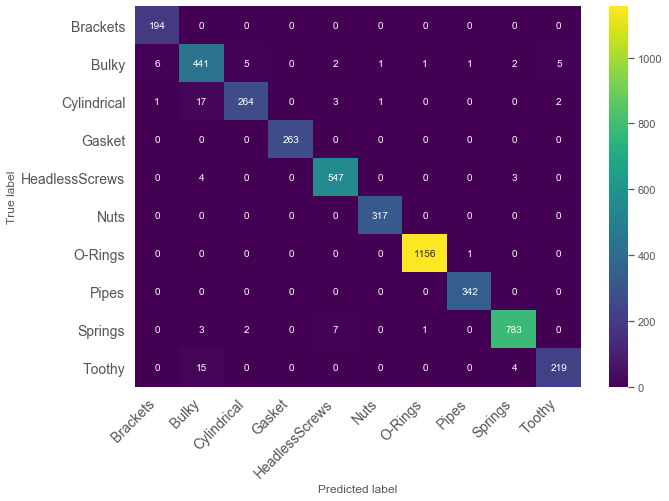

In [16]:
# print confusion matrix
labels = list(trainFile["label_names"])
labels = [label.decode() for label in labels]
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(testy.argmax(axis=1),
                    preds.argmax(axis=1),
                    )

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):

    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap='viridis')
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

print_confusion_matrix(cm, class_names=labels)

In [17]:
## load the model
loaded_model = load_model(f"{dbBase}//model_mvcnn_color_roi_10class_28px1px_255_minvgg.h5")

In [18]:
for layer in loaded_model.layers:
    print(layer)

In [20]:
flatten_layer = loaded_model.layers[16]
retrieval_model = Model(inputs=loaded_model.input, outputs=flatten_layer.output)
retrieval_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_input (InputLayer)    [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
activation (Activation)      (None, 28, 28, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128   